In [1]:
import os
import json
import pandas as pd
from kloppy import wyscout
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import unicodedata
import codecs
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None)

In [2]:
# -------------------------------
# JSON Dosyalarını Oku
# -------------------------------
project_dir = Path(os.getcwd())
players_path = project_dir / "wyscout" / "players.json"
teams_path   = project_dir / "wyscout" / "teams.json"

with open(players_path, 'r', encoding='utf-8') as f:
    players_data = json.load(f)
players_df = pd.DataFrame(players_data)

with open(teams_path, 'r', encoding='utf-8') as f:
    teams_data = json.load(f)
teams_df = pd.DataFrame(teams_data)

In [3]:
players_df

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,"{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",120839,left,A. Ma\u00e2loul,null
3599,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114736,right,C. C\u00e1ceda,null
3600,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114908,right,M. Araujo,null
3601,"{'name': 'Morocco', 'id': 504, 'alpha3code': '...",70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Morocco', 'id': 504, 'alpha3code': '...",285583,right,A. Tagnaouti,null


In [4]:
teams_df

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
...,...,...,...,...,...,...
137,Las Rozas,Spain,1598,Spain,"{'name': 'Spain', 'id': 724, 'alpha3code': 'ES...",national
138,Beograd,Serbia,17322,Serbia,"{'name': 'Serbia', 'id': 688, 'alpha3code': 'S...",national
139,Bern,Switzerland,6697,Switzerland,"{'name': 'Switzerland', 'id': 756, 'alpha3code...",national
140,Warszawa,Poland,13869,Poland,"{'name': 'Poland', 'id': 616, 'alpha3code': 'P...",national


Wyscout

In [5]:
# matches_England.json dosyasının tam path'i
matches_json_path = project_dir / "wyscout" / "matches_Germany.json"

# JSON'u oku  
with open(matches_json_path, "r", encoding="utf-8") as f:
    matches = json.load(f)

# Tüm wyId'leri al, unique yap, küçükten büyüğe sırala
match_ids = sorted(set(match["wyId"] for match in matches))
print(f"Toplam {len(match_ids)} unique maç bulundu.")

# Her maç için ayrı DF oluştur, listeye ekle
dfs = []
failed_matches = []

for mid in match_ids:
    try:
        ds = wyscout.load_open_data(match_id=mid)
        df = ds.to_pandas()  # EventDataset -> DataFrame
        df["matchId"] = mid   # match_id kolonu ekle
        dfs.append(df)
    except Exception as e:
        print(f"Match {mid} yüklenirken hata oluştu: {e}")
        failed_matches.append(mid)
        continue

# Tüm DF'leri concat et
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    print("Tüm maçlar başarıyla birleştirildi.")
    print(f"Toplam event sayısı: {len(full_df)}")
else:
    print("Hiçbir maç yüklenemedi.")

if failed_matches:
    print("Başarısız maçlar:", failed_matches)


Toplam 306 unique maç bulundu.


C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Meg

Match 2516925 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Meg

Match 2516994 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Meg

Match 2517007 yüklenirken hata oluştu: 'NoneType' object is not subscriptable


C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Megad\AppData\Local\Temp\ipykernel_17308\2057436882.py:19: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = ds.to_pandas()  # EventDataset -> DataFrame
C:\Users\Meg

Tüm maçlar başarıyla birleştirildi.
Toplam event sayısı: 528771
Başarısız maçlar: [2516925, 2516994, 2517007]


In [6]:
# ID sütunlarını integer yap
full_df['player_id'] = full_df['player_id'].fillna(0).astype(int)
full_df['team_id'] = full_df['team_id'].fillna(0).astype(int)
players_df['wyId'] = players_df['wyId'].astype(int)
teams_df['wyId'] = teams_df['wyId'].astype(int)

# Unicode escape dizilerini çöz
def decode_unicode_escapes(name):
    if pd.isna(name):
        return name
    return codecs.decode(name, 'unicode_escape')

# Mapping
player_map = dict(zip(players_df['wyId'], players_df['shortName'].apply(decode_unicode_escapes)))
team_map = dict(zip(teams_df['wyId'], teams_df['name'].apply(decode_unicode_escapes)))

full_df['player_name'] = full_df['player_id'].map(player_map)
full_df['team_name'] = full_df['team_id'].map(team_map)

# Kontrol
full_df[['player_id','player_name','team_id','team_name']].head()


,player_id,player_name,team_id,team_name
0,15231,K. Volland,2446,Bayer Leverkusen
1,14786,K. Bellarabi,2446,Bayer Leverkusen
2,14803,S. Bender,2446,Bayer Leverkusen
3,14768,B. Leno,2446,Bayer Leverkusen
4,14803,S. Bender,2446,Bayer Leverkusen


In [7]:
full_df

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,matchId,player_name,team_name
0,179896442,PASS,1,0 days 00:00:02.409746,None,None,None,2446,15231,0.500000,0.500000,0.500000,0.482059,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2516739,K. Volland,Bayer Leverkusen
1,179896443,PASS,1,0 days 00:00:02.506082,None,None,None,2446,14786,0.500000,0.482059,0.232095,0.230490,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2516739,K. Bellarabi,Bayer Leverkusen
2,179896444,PASS,1,0 days 00:00:06.946706,None,None,None,2446,14803,0.232095,0.230490,0.052381,0.464118,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2516739,S. Bender,Bayer Leverkusen
3,179896445,PASS,1,0 days 00:00:10.786491,None,None,None,2446,14768,0.052381,0.464118,0.213226,0.107121,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2516739,B. Leno,Bayer Leverkusen
4,179896446,PASS,1,0 days 00:00:12.684514,None,None,None,2446,14803,0.213226,0.107121,0.279267,0.042848,NaN,False,SIMPLE_PASS,COMPLETE,True,NaN,NaN,NaN,NaN,NaN,2516739,S. Bender,Bayer Leverkusen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528766,251206867,DUEL,2,0 days 00:47:05.097992,None,None,None,2463,15317,0.908333,0.096409,NaN,NaN,NaN,False,NaN,NEUTRAL,False,GROUND,NaN,NaN,NaN,NaN,2517044,L. Bittencourt,Köln
528767,251206788,DUEL,2,0 days 00:47:05.519102,None,None,None,2451,14804,0.104762,0.935728,NaN,NaN,NaN,False,NaN,WON,True,GROUND,NaN,NaN,NaN,NaN,2517044,J. Błaszczykowski,Wolfsburg
528768,251206868,DUEL,2,0 days 00:47:06.053788,None,None,None,2463,15317,0.895238,0.064272,NaN,NaN,NaN,False,NaN,LOST,False,GROUND,NaN,NaN,NaN,NaN,2517044,L. Bittencourt,Köln
528769,251206790,PASS,2,0 days 00:47:08.080925,None,None,None,2451,14804,0.000000,0.946440,0.043651,0.925015,NaN,False,SIMPLE_PASS,INCOMPLETE,False,NaN,NaN,NaN,NaN,NaN,2517044,J. Błaszczykowski,Wolfsburg


Benchmark

In [8]:
# DataFrame'e çevir
df_matches = pd.DataFrame(matches)

# dateutc'ye göre sırala
df_matches['dateutc'] = pd.to_datetime(df_matches['dateutc'])
df_matches = df_matches.sort_values('dateutc').reset_index(drop=True)

# Maç sonuçlarını temsil eden label değerleri
def result_from_label(label):
    if ',' not in label:
        return 'X'
    score_str = label.split(',')[-1].strip()  # "1 - 2" kısmı
    home, away = map(int, score_str.split(' - '))
    if home > away:
        return 'H'
    elif home < away:
        return 'A'
    else:
        return 'D'

df_matches['result'] = df_matches['label'].apply(result_from_label)

possible_results = ['H', 'D', 'A']

# 1) Full random tahmin
full_random_preds = np.random.choice(possible_results, size=len(df_matches))
df_matches['full_random'] = full_random_preds

# 2) İlk maç random, sonraki maçlar önceki maç sonucundan farklı tahmin
prev_diff_preds = []
for i in range(len(df_matches)):
    if i == 0:
        pred = np.random.choice(possible_results)
    else:
        prev_result = prev_diff_preds[-1]
        pred = np.random.choice([r for r in possible_results if r != prev_result])
    prev_diff_preds.append(pred)

df_matches['prev_diff'] = prev_diff_preds

# Doğru tahmin yüzdeleri
accuracy_full_random = (df_matches['result'] == df_matches['full_random']).mean()
accuracy_prev_diff = (df_matches['result'] == df_matches['prev_diff']).mean()

print(f"Full random doğru tahmin yüzdesi: {accuracy_full_random*100:.2f}%")
print(f"Prev-diff doğru tahmin yüzdesi: {accuracy_prev_diff*100:.2f}%")

# 3x3 sonuç matrisi
conf_matrix_full_random = pd.crosstab(df_matches['result'], df_matches['full_random'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
conf_matrix_prev_diff = pd.crosstab(df_matches['result'], df_matches['prev_diff'], rownames=['Actual'], colnames=['Predicted'], dropna=False)

# Matrisleri eksik değerleri doldurarak sırala
conf_matrix_full_random = conf_matrix_full_random.reindex(index=possible_results, columns=possible_results, fill_value=0)
conf_matrix_prev_diff = conf_matrix_prev_diff.reindex(index=possible_results, columns=possible_results, fill_value=0)

print("\nFull Random 3x3 Matrisi:")
print(conf_matrix_full_random)
print("\nPrev-Diff 3x3 Matrisi:")
print(conf_matrix_prev_diff)


Full random doğru tahmin yüzdesi: 34.64%
Prev-diff doğru tahmin yüzdesi: 35.95%

Full Random 3x3 Matrisi:
Predicted   H   D   A
Actual               
H          53  40  46
D          26  28  29
A          35  24  25

Prev-Diff 3x3 Matrisi:
Predicted   H   D   A
Actual               
H          47  47  45
D          28  32  23
A          22  31  31


model

Overall Match Prediction Accuracy: 0.45901639344262296


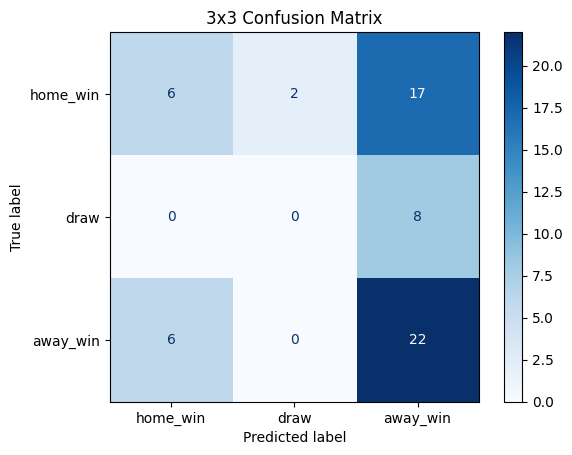

,matchId,team_name,event_PASS_count,event_DUEL_count,event_BALL_OUT_count,distinct_players,distance_avg,distance_std,pass_type_SIMPLE_PASS_count,pass_type_HIGH_PASS_count,pass_type_LAUNCH_count,pass_type_HAND_PASS_count,pass_type_HEAD_PASS_count,pass_type_SMART_PASS_count,pass_type_THROUGH_BALL_count,success_rate,body_part_type_HEAD_count,body_part_type_RIGHT_FOOT_count,duel_type_AERIAL_count,duel_type_GROUND_count,duel_type_SLIDING_TACKLE_count,set_piece_type_GOAL_KICK_count,set_piece_type_FREE_KICK_count,set_piece_type_THROW_IN_count,goalkeeper_type_SAVE_count,goalkeeper_type_REFLEX_count,card_type_FIRST_YELLOW_count,pass_type_CROSS_count,pass_type_ASSIST_count,body_part_type_LEFT_FOOT_count,body_part_type_KEEPER_ARM_count,body_part_type_HEAD_OTHER_count,set_piece_type_CORNER_KICK_count,goalkeeper_type_SAVE_ATTEMPT_count,card_type_RED_count,set_piece_type_PENALTY_count,card_type_SECOND_YELLOW_count
0,2516739,Bayer Leverkusen,145,56,22,12,0.130963,0.179781,117,11,4.0,3,3,1.0,1.0,0.705069,3,5.0,7,48,1.0,2.0,3.0,3,1.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2516739,Bayern München,196,55,1,12,0.190787,0.199690,144,16,1.0,13,6,1.0,3.0,0.752896,6,4.0,6,47,2.0,3.0,7.0,12,NaN,6.0,NaN,1.0,2.0,3.0,1.0,2.0,3.0,1.0,NaN,NaN,NaN
2,2516740,Hoffenheim,238,55,0,12,0.184541,0.173903,209,8,1.0,6,2,1.0,4.0,0.782895,2,3.0,6,48,1.0,4.0,5.0,6,NaN,NaN,NaN,1.0,NaN,3.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN
3,2516740,Werder Bremen,125,59,28,12,0.146275,0.218394,76,14,5.0,8,8,2.0,1.0,0.619289,8,4.0,5,53,1.0,7.0,3.0,6,NaN,NaN,2.0,1.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
4,2516741,Hertha BSC,249,72,0,12,0.179103,0.178152,196,20,1.0,6,15,2.0,1.0,0.761905,15,5.0,17,54,1.0,NaN,6.0,6,1.0,NaN,NaN,1.0,NaN,4.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN


In [9]:
# -------------------------------
# 1️⃣ İlk 30 Dakika Filtresi
# -------------------------------
df = full_df.copy()
df['seconds'] = df['timestamp'].dt.total_seconds()
first_30_min = df[(df['period_id'] == 1) & (df['seconds'] <= 1800)]

# -------------------------------
# 2️⃣ Fonksiyon: Mesafe Hesaplama
# -------------------------------
def compute_distance(row):
    if pd.notna(row['end_coordinates_x']) and pd.notna(row['end_coordinates_y']):
        dx = row['end_coordinates_x'] - row['coordinates_x']
        dy = row['end_coordinates_y'] - row['coordinates_y']
        return np.sqrt(dx**2 + dy**2)
    else:
        return 0

# -------------------------------
# 3️⃣ Fonksiyon: Maç + Takım Bazlı Detaylı Özet
# -------------------------------
def summarize_match_team(df):
    df = df.copy()
    df['distance'] = df.apply(compute_distance, axis=1)
    features = []

    grouped = df.groupby(['matchId', 'team_name'])
    for (matchId, team_name), group in grouped:
        feat = {'matchId': matchId, 'team_name': team_name}

        for evt in ['PASS','DUEL','BALL_OUT']:
            feat[f'event_{evt}_count'] = (group['event_type'] == evt).sum()
        feat['distinct_players'] = group['player_id'].nunique()
        feat['distance_avg'] = group['distance'].mean()
        feat['distance_std'] = group['distance'].std()

        for ptype in group['pass_type'].dropna().unique():
            feat[f'pass_type_{ptype}_count'] = (group['pass_type'] == ptype).sum()
        feat['success_rate'] = group['success'].mean() if 'success' in group else np.nan

        for col in ['body_part_type','duel_type','set_piece_type','goalkeeper_type','card_type']:
            for val in group[col].dropna().unique():
                feat[f'{col}_{val}_count'] = (group[col] == val).sum()
        features.append(feat)

    match_team_features = pd.DataFrame(features)
    return match_team_features

# -------------------------------
# 4️⃣ Fonksiyon: Maç Bazlı Özet
# -------------------------------
def summarize_match(df):
    result_counts = df.pivot_table(index='matchId', columns='result', aggfunc='size', fill_value=0)
    result_counts.columns = [f'result_{col}_count' for col in result_counts.columns]

    agg_dict = {
        'pass_type': lambda x: x.nunique(),
        'coordinates_x': ['mean', 'std'],
        'coordinates_y': ['mean', 'std'],
        'player_id': lambda x: x.nunique()
    }
    summary = df.groupby('matchId').agg(agg_dict)
    summary.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in summary.columns.values]
    summary = summary.merge(result_counts, left_index=True, right_index=True)

    if 'COMPLETE' in df['result'].unique():
        complete_counts = df[df['result']=='COMPLETE'].groupby('matchId').size()
        total_counts = df.groupby('matchId').size()
        summary['pass_success_rate'] = complete_counts / total_counts
    else:
        summary['pass_success_rate'] = np.nan

    if 'match_date' in df.columns:
        dates = df.groupby('matchId')['match_date'].first()
        summary = summary.merge(dates, left_index=True, right_index=True)

    return summary

def clean_column_names(df):
    df = df.copy()
    df.columns = [str(col).replace('[','_').replace(']','').replace('<','_').replace('>','_').replace(' ','_') for col in df.columns]
    return df

# -------------------------------
# 5️⃣ Maç Özeti ve Skorlar
# -------------------------------
match_features = summarize_match(first_30_min)
match_features = clean_column_names(match_features)

np.random.seed(42)
match_scores = pd.DataFrame({
    'matchId': match_features.index,
    'home_score': np.random.randint(0,5,len(match_features)),
    'away_score': np.random.randint(0,5,len(match_features))
})

match_features = match_features.merge(match_scores, on='matchId')
match_features['draw'] = (match_features['home_score'] == match_features['away_score']).astype(int)
match_features['winner'] = match_features.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 0, axis=1)

# -------------------------------
# 6️⃣ Train/Test Split
# -------------------------------
match_features = match_features.sort_values(by='match_date') if 'match_date' in match_features.columns else match_features
n = len(match_features)
train_size = int(0.8 * n)

train_data = match_features.iloc[:train_size]
test_data = match_features.iloc[train_size:]

X_train = train_data.drop(columns=['home_score','away_score','draw','winner','match_date'], errors='ignore')
y_train_draw = train_data['draw']
y_train_winner = train_data['winner']

X_test = test_data.drop(columns=['home_score','away_score','draw','winner','match_date'], errors='ignore')
y_test_draw = test_data['draw']
y_test_winner = test_data['winner']

# -------------------------------
# 🔹 Stage 1: Draw tahmini
# -------------------------------
model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage1.fit(X_train, y_train_draw)

# -------------------------------
# 🔹 Stage 2: Home/Away winner tahmini (draw olmayanlar)
# -------------------------------
X_train_no_draw = X_train[y_train_draw==0]
y_train_winner_no_draw = y_train_winner[y_train_draw==0]
model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage2.fit(X_train_no_draw, y_train_winner_no_draw)

# -------------------------------
# 🔹 Test Seti Tahminleri
# -------------------------------
overall_pred = []
for idx, row in test_data.iterrows():
    X = row.drop(labels=['home_score','away_score','draw','winner','match_date'], errors='ignore').to_frame().T
    draw_pred = model_stage1.predict(X)[0]
    if draw_pred == 1:
        overall_pred.append('draw')
    else:
        winner_pred = model_stage2.predict(X)[0]
        overall_pred.append('home_win' if winner_pred == 1 else 'away_win')

# Gerçek sonuçlar
def real_result(row):
    if row['draw'] == 1:
        return 'draw'
    else:
        return 'home_win' if row['winner'] == 1 else 'away_win'

real_results = test_data.apply(real_result, axis=1)

# Overall accuracy
overall_acc = accuracy_score(real_results, overall_pred)
print("Overall Match Prediction Accuracy:", overall_acc)

# -------------------------------
# 🔹 3x3 Confusion Matrix
# -------------------------------
labels = ['home_win', 'draw', 'away_win']
cm = confusion_matrix(real_results, overall_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("3x3 Confusion Matrix")
plt.show()

# -------------------------------
# 🔹 Detaylı Maç+Takım Özeti
# -------------------------------
match_team_features = summarize_match_team(first_30_min)
match_team_features.head()


Statsbomb

In [10]:
from statsbombpy import sb

sb.competitions()

c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882
...,...,...,...,...,...,...,...,...,...,...,...,...
70,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2024-02-12T14:45:05.702250,2021-06-13T16:17:31.694,None,2024-02-12T14:45:05.702250
71,53,315,Europe,UEFA Women's Euro,female,False,True,2025,2025-07-28T14:19:20.467348,2025-07-29T16:03:07.355174,2025-07-29T16:03:07.355174,2025-07-28T14:19:20.467348
72,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2024-02-13T13:27:17.178263,2024-02-13T13:30:52.820588,2024-02-13T13:30:52.820588,2024-02-13T13:27:17.178263
73,72,107,International,Women's World Cup,female,False,True,2023,2025-07-14T10:07:06.620906,2025-07-14T10:10:27.224586,2025-07-14T10:10:27.224586,2025-07-14T10:07:06.620906


clubelo